This notebook was designed to work with [Google Colab](https://colab.research.google.com/github/lokdoesdata/syracuse-assorted/blob/main/ist_652/homework_1/lok_ngan_homework_1.ipynb).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lokdoesdata/syracuse-assorted/blob/main/ist_652/homework_1/lok_ngan_homework_1.ipynb)

# IST 652 - Homework 1: Structured Data
Lok Ngan

Due: May 4, 2021

-------------
In this exercise, a small dataset containing donor data would be used to illustrate some fundamental techniques in data mainpulation and visualization using Python.  

## Set Up

For this exercise, popular Python packages [`pandas`](https://pandas.pydata.org/pandas-docs/stable/getting_started/install.html), [`matplotlib`](https://matplotlib.org/stable/users/installing.html), and [`seaborn`](https://seaborn.pydata.org/installing.html) were used.  `Pathlib` was also used, but it comes with Python>=3.6.

* `Pandas` is a popular data manipulation package.  
* `Matplotlib` is a graphical library that can be used to create static, animated or interactive visuals.
* `Seaborn` is a graphical library built on top of `matplotlib`.
* `Pathlib` is used to handles I/O.

In [2]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

## I/O

The data is moved to Github.  An output folder would be created in the current working directory if one does not exist.

In [3]:
# set up data path; path is from Github
DATA_PATH = r'https://raw.githubusercontent.com/lokdoesdata/syracuse-assorted/main/ist_652/homework_1/data/donors_data.csv'

In [4]:
# create output folder
OUTPUT_PATH = Path.cwd().joinpath('output')
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

## Data

There are 24 columns in the data set:

| Column Header   | Description                                             |
| :-------------- | :------------------------------------------------------ |
| Row Id          | INDEX                                                   |
| Row Id.         | ID Number                                               |
| zipconvert_2    | Region 2 (Onehot encoded)                               |
| zipconvert_3    | Region 3 (Onehot encoded)                               |
| zipconvert_4    | Region 4 (Onehot encoded)                               |
| zipconvert_5    | Region 5 (Onehot encoded)                               |
| homeowner dummy | Is homeowner?                                           |
| NUMCHLD         | Number of Children                                      |
| INCOME          | Household income                                        |
| gender dummy    | Gender (0 = Male, 1 = Female)                           |
| WEALTH          | Wealth rating (9 is highest, 0 is lowest)               |
| HV              | Median Home Value of Potential Donor's neighborhood     |
| Icmed           | Median Family Income of Potential Donor's neighborhood  |
| Icavg           | Average Family Income of Potential Donor's neighborhood |
| IC15            | Percent "Low Income" of Potential Donor's neighborhood  |
| NUMPROM         | Lifetime number of promotions received                  |
| RAMNTALL        | Dollar amount of lifetime gifts to date                 |
| MAXRAMNT        | Dollar amount of largest gift to date                   |
| LASTGIFT        | Dollar amount of most recent gift                       |
| totalmonths     | Number of months since last donation                    |
| TIMELAG         | Number of months between first and second gift          |
| AVGGIFT         | Average dollar amount of gifts to date                  |
| TARGET_B        | Is Donor?                                               |
| TARGET_D        | Donation Amount                                         |

In [5]:
df = pd.read_csv(DATA_PATH, index_col = 0)

### Data Manipulation

The onehot encoded zip codes were converted into one single column for ease of data visualization.  This was done with a helper function.

In [6]:
def de_onehot_encoder(zip2, zip3, zip4, zip5):
    """Create a label encoded output based on the zipcode"""

    if zip2:
        return(2)
    elif zip3:
        return(3)
    elif zip4:
        return(4)
    elif zip5:
        return(5)
    else:
        return(1)

df['zip'] = df[['zipconvert_2', 'zipconvert_3', 'zipconvert_4', 'zipconvert_5']].apply(
    lambda x: de_onehot_encoder(*x), axis=1)

Added a column with value 1 for simple aggregation

In [7]:
df['cnt'] = 1

Remove uneeded columns

In [8]:
df.drop([
    'Row Id.', 
    'zipconvert_2', 
    'zipconvert_3', 
    'zipconvert_4', 
    'zipconvert_5'
    ], axis=1, inplace=True)

## Data Question

### 1. What are the number of donors by gender in each wealth group?

The data has a lot more people in wealth category "8" than any other category.  The distribution of gender looks mostly even across the 10 wealth categories, with the exception of "8" which has more females than males.

In [9]:
df_gender_by_wealth_group = df.groupby('WEALTH', as_index = False).agg(
    {
        'cnt': 'sum',
        'gender dummy': 'sum'
    })

df_gender_by_wealth_group.sort_values('WEALTH', ascending=False, inplace=True)
df_gender_by_wealth_group['WEALTH'] = df_gender_by_wealth_group['WEALTH'].astype(str)

#### Table

In [10]:
df_gender_by_wealth_group

,WEALTH,cnt,gender dummy
9,9,189,114
8,8,1700,1040
7,7,180,104
6,6,162,88
5,5,186,108
4,4,153,88
3,3,162,96
2,2,138,92
1,1,138,85
0,0,112,86


#### Chart

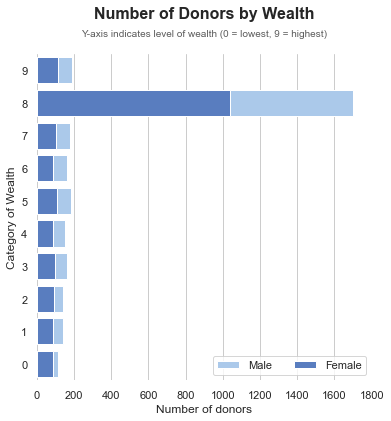

In [13]:
f, ax = plt.subplots(figsize=(6, 6))
sns.set_theme(style="whitegrid")

sns.set_color_codes("pastel")
sns.barplot(
    data=df_gender_by_wealth_group,
    x='cnt',
    y='WEALTH',
    orient='h',        
    label='Male',
    color='b',
    ax=ax
)

sns.set_color_codes("muted")
sns.barplot(
    data=df_gender_by_wealth_group,
    x='gender dummy',
    y='WEALTH',
    orient='h',        
    label='Female',
    color='b',
    ax=ax
)

ax.legend(ncol=2, loc='lower right', frameon=True)

ax.set(
    xlim=(0, 1800), 
    ylabel='Category of Wealth',
    xlabel='Number of donors'
    )

ax.text(x=0.5, y=1.1, s='Number of Donors by Wealth', fontsize=16, weight='bold', ha='center', va='bottom', transform=ax.transAxes)

ax.text(x=0.5, y=1.05, s='Y-axis indicates level of wealth (0 = lowest, 9 = highest)', fontsize=10, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

sns.despine(left=True, bottom=True)

### 2. What is the distribution of average donation by wealth group and gender?

The data suggested that males tend to donate more than females with similar wealth.  Average donation amount also tend to trend upward along with increasing wealth, but not by a significant amount.

In [14]:
df_donation_by_wealth_and_gender = df.copy()[['WEALTH', 'gender dummy', 'AVGGIFT']]
df_donation_by_wealth_and_gender.sort_values('WEALTH', inplace=True)

df_donation_by_wealth_and_gender['WEALTH'] = df_donation_by_wealth_and_gender['WEALTH'].astype(str)
df_donation_by_wealth_and_gender['gender dummy'] = df_donation_by_wealth_and_gender['gender dummy'].apply(lambda x: {0:'Male', 1:'Female'}.get(x))

#### Table

In [15]:
df_donation_by_wealth_and_gender

,WEALTH,gender dummy,AVGGIFT
Row Id,,,
2464,0,Female,5.550000
2404,0,Female,17.875000
682,0,Female,5.750000
3055,0,Female,8.100000
1695,0,Male,6.500000
...,...,...,...
806,9,Female,15.400000
1217,9,Female,10.000000
2060,9,Male,10.777778


#### Chart

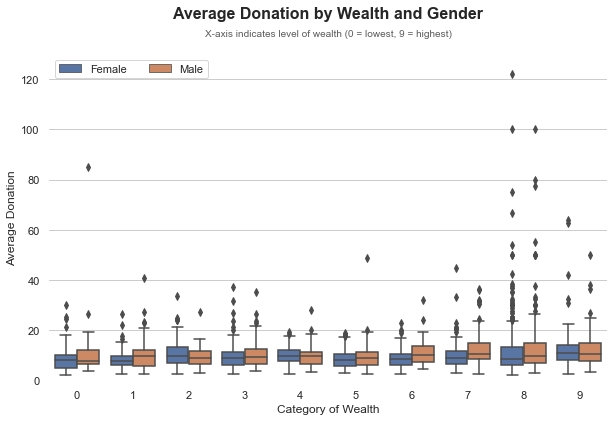

In [16]:
f, ax2 = plt.subplots(figsize=(10, 6))
sns.set_theme(style="whitegrid")

g = sns.boxplot(
    data=df_donation_by_wealth_and_gender, 
    x='WEALTH', y='AVGGIFT', hue='gender dummy',
    ax=ax2
)

g.legend(ncol=2, loc='upper left', frameon=True)

g.set(
    ylim=(0, 130), 
    xlabel='Category of Wealth',
    ylabel='Average Donation'
    )

g.text(x=0.5, y=1.1, s='Average Donation by Wealth and Gender', fontsize=16, weight='bold', ha='center', va='bottom', transform=g.transAxes)

g.text(x=0.5, y=1.05, s='X-axis indicates level of wealth (0 = lowest, 9 = highest)', fontsize=10, alpha=0.75, ha='center', va='bottom', transform=g.transAxes)

sns.despine(left=True, bottom=True)

## Output

Output the DataFrame into a .xlsx file.

In [18]:
with pd.ExcelWriter(OUTPUT_PATH.joinpath('lok_ngan_homework_1_output.xlsx')) as writer:
    df_gender_by_wealth_group.to_excel(writer, sheet_name='GenderByWeath', index=False)
    df_donation_by_wealth_and_gender.to_excel(writer, sheet_name='DonationByGenderAndWealth', index=False)

A copy of the output file can be obtained [here](r'https://raw.githubusercontent.com/lokdoesdata/syracuse-assorted/main/ist_652/homework_1/output/lok_ngan_homework_1_output.xlsx)